# 3 Lane 2 motor flow 

## 2 hops for both motor, can hop over each other
In this notebook we model 3 channel flow model

The code is mostly the same as the previous one, only `canHopForwardSameChannel` and `canHopToOtherChannel` are changed, so that they check not the entire track but only the final position where the particle can jump.

<hr>

Also a rate of 5 epochs for particle A and 3 epochs for particle B(ie one particle A per % epochs and one particle B per 3 epochs is used)

## Track Description
We take the size of the model to be 3 x 1000, 3 channels and 1000 lattice sites per channel

In [1]:
numRows = 3
numColumns = 1000

In [2]:
import numpy as np
from random import random

## Add Queue for each site

Matrix for keeping each queue
For getting a particular queue we will use `queue[channel number][site number]`

In [3]:
from collections import deque

In [4]:
queue = [ [None] * numColumns] * numRows

In [5]:
for i in range(numRows):
    for j in range(numColumns):
        queue[i][j] = deque()

## Set the motor types and various motor parameters
1. Set the motor types

In [6]:
motorA = 1
motorB = 2
vacancy = 0

## Hop of Motor for Both is 2, this time they can hop over each other

In [7]:
def hopOf(motorType):
    if motorType == motorA:
        return 2  # Hop of motor A
    return 2    # Hop of motor B    

### Utility Functions
Note : `currentPosition = (currentChannel, currentSite)`

1. `canHopForwardSameChannel` : Function to check if motor can jump to forward site

In [8]:
def canHopForwardSameChannel(currentPosition):
    # Returns False if any position infront is occupied
    ## Version 2- can hop over, so need to see if final position is empty only
    val = not track[currentPosition[0],
                    currentPosition[1] + hopOf(track[currentPosition])]
    return val

2. `canHopToOtherChannel` : Function to check if hop to other channel or not

In [9]:
def canHopToOtherChannel(currentPosition):
    # Returns True if can Hop to other channel
    #### Checks only final position as jumping allowed
    
    jumpChannels = [0, 1, 2]
    jumpChannels.remove(currentPosition[0]) # Remove current channel
    
    finalSite = currentPosition[1] + hopOf(track[currentPosition])  # Final site
    
    c1, c2 = jumpChannels   # Channels to jump into
    
    channel1 = track[c1, finalSite]   # Is any in slice occupied?
    channel2 = track[c2, finalSite]   #is any in slice occupied 
    return not(channel1 or channel2)

3. `getFinalPosition` : Function to determine the final jump position of the motor

In [10]:
from numpy.random import permutation

In [11]:
def getFinalPosition(currentPosition, sameChannel = True):
    
    # print("get final position")
    
    finalSite = currentPosition[1] + hopOf(track[currentPosition])
    
    if finalSite >= numColumns:     # Send 'Exit' if particle can get out of track
        return "Exit"
    else:
        if sameChannel:
            return (currentPosition[0], finalSite)    # Final position for Same Channel
        else:
            jumpChannels = [0, 1, 2]
            jumpChannels.remove(currentPosition[0])    # Remove the current channel
    
            c1, c2 = permutation(jumpChannels)
            if not track[c1, finalSite]:
                return (c1, finalSite)
            else:
                return (c2, finalSite)

4. `jump` : Conducts the jump between _source_ and _destination_. If particle goes out, it discards it

In [12]:
def jump(source, destination):
    
    if destination == 'Exit':
        track[source] = vacancy
        return          # If can exit, throw motor out
    
    track[source], track[destination] = track[destination], track[source]

5. `step` : Takes the step for the motor. Whether to hopForward or change Channel or to go in Queue

In [13]:
def step(currentPosition):
    if canHopForwardSameChannel(currentPosition):    # Go forward
        
        finalPosition = getFinalPosition(currentPosition)
        jump(currentPosition, finalPosition)
        
    elif canHopToOtherChannel(currentPosition):      # If obstacle, try to change lane
        
        finalPosition = getFinalPosition(currentPosition, sameChannel = False)
        jump(currentPosition, finalPosition)       
        
    else:
        queue[currentPosition[0]][currentPosition[1]].append(track[currentPosition])    # In nothing happens, go in queue and wait for your turn
        track[currentPosition] = vacancy
        # print(f"Final track Position value:{track[currentPosition]}")   # <!-- Should give a value of 0 -->

6. `queueStep` : Takes the step for the queued motors

In [14]:
from random import shuffle

In [15]:
# Function to pop out elements and put it in place, assuming legal jump allowed
def queueToChannel(currPosition, channelToMove):
    motor_value = queue[currPosition[0]][currPosition[1]][0]
    finalPosition = currPosition[1] + hopOf(motor_value)   # get final position motor can jump to
    if finalPosition < numColumns:
        motor = queue[currPosition[0]][currPosition[1]].popleft()  # Get motor    
        track[channelToMove, finalPosition] = motor  # Put motor in place
    return

In [16]:
# queue to current site but different channel move
# Return True if changed here
def queueToSameSite(currPosition, same_channel, lateral_channel):
    channels = [0, 1, 2]         # All channels    
    c1, c2, c3 = permutation(channels)    # Put in c1, c2, c3
    finalSite = currPosition[1]
    
    currentChannel = currPosition[0]     # get current channel
    
    p = random()    # For random channel selection

    if track[c1, finalSite] == 0:    # Check if can go to channel 1
        threshold = same_channel if (c1 == currentChannel) else lateral_channel
        if p > threshold:
            track[c1, finalSite] = queue[currPosition[0]][currPosition[1]].popleft()
            return True

    elif track[c2, finalSite] == 0:    # Check if can go to channel 2
        threshold = same_channel if (c2 == currentChannel) else lateral_channel
        if p > threshold:
            track[c2, finalSite] = queue[currPosition[0]][currPosition[1]].popleft()
            return True

    elif track[c3, finalSite] == 0:    # Check if can go to channel 3
        threshold = same_channel if (c3 == currentChannel) else lateral_channel
        if p > threshold:
            track[c3, finalSite] = queue[currPosition[0]][currPosition[1]].popleft()
            return True

    return False    # Executed if None of this is possible

In [17]:
# Action for elements in queue
def queueStep(currChannel, currSite):
    lateral_channel = 0.45
    same_channel = 0.55
    
    currPosition = (currChannel, currSite)  # Curent Position
    
    # Same site, different channel movement, if True return
    if queueToSameSite(currPosition, same_channel, lateral_channel): return  

    # If hop forward in same or different channel
    channels = [0, 1, 2]         # All channels
    
    c1, c2, c3 = permutation(channels)    # Put in c1, c2, c3

    motorToExitType = queue[currChannel][currSite][0]
    finalSite = currSite  + hopOf(motorToExitType)  # final position after jump
    
    p = random()    # Generate a random number

    if finalSite < numColumns:   #Checks if exiting or not
        if not any(track[c1, currSite + 1  : finalSite + 1]):
            threshold = same_channel if (c1 == currChannel) else lateral_channel
            if p > threshold:
                queueToChannel(currPosition, c1)
                return 

        elif not any(track[c2, currSite+1 : finalSite + 1]):    # Check if can go to channel 2
            threshold = same_channel if (c1 == currChannel) else lateral_channel
            if p > threshold:
                queueToChannel(currPosition, c2)
                return

        elif not any(track[c3, currSite+1 : finalSite + 1]):    # Check if can go to channel 3
            threshold = same_channel if (c1 == currChannel) else lateral_channel
            if p > threshold:
                queueToChannel(currPosition, c3)
                return

## Simulation Codes

In [18]:
from random import choice

In [19]:
def putInTrack(motorType):
    # Put motor of motorType in the track
    rows = permutation([0, 1, 2])
    for row in rows:
        if track[row][0] == vacancy:
            track[row][0] = motorType
            break   

In [21]:
'''
####<!-- This code was used in the previous version to first fill the entire track with particles and then run the simulation -->
#-----------------------------------------------------------------------------------------------------------------------------------
    count_a = count_a  
    count_b = count_b    
    
    while True:    # Till the track is filled
        
        if count_a > 0 and count_b > 0:       # If both have valid number of motors to input
            motorType, channel, site = choice([motorA, motorB]), choice(range(numRows)), choice(range(numColumns))
        elif count_a == 0:
            if count_b > 0:
                motorType, channel, site = motorB, choice(range(numRows)), choice(range(numColumns))  # if no a, do b
            else: break
        elif count_b == 0:
            if count_a > 0:
                motorType, channel, site = motorA, choice(range(numRows)), choice(range(numColumns)) # if no b, do a
            else: break       
        
        if track[channel, site] == vacancy:    # If empty, fill
            track[channel, site] = motorType
            if motorType == motorA:    # reduce_Count_of_variables
                count_a -= 1
            else:
                count_b -= 1
                
    print(f"#Remaining a : {count_a}, #Remaining b : {count_b}")   # If correct, should be 0 for bot''';

In [22]:
# Get count of all motors of a particular type in the track
def count_motor():
    return np.bincount(np.ravel(track))    # returned value is [#vacancy, #motorA, #motorB], extract with respective indexes

In [23]:
import matplotlib.pyplot as plt
import os
import PIL
%matplotlib inline

## Fill track
Particles were added as per their rate here

In [25]:

'''# we will take the model to be 3x1000 matrices


# Let us fill the track
fillTrack(200, 200)

print("Initial:" ,count_motor())
''';

In [26]:
from random import random

### I have commented out the section dealing with plotting as it is taking lot of time to run

In [27]:
def simulate_model(n_epochs):
    # Simulates the entire workflow
    # Make movements
    for epoch in range(n_epochs):
        
        for site in range(numColumns-1, -1, -1):  
            for channel in range(numRows):
                
                if track[channel, site] == 0:          # If we have empty track, then try dequeing
                    if len(queue[channel][site]) !=  0:
                        queueStep(channel, site)        # If nonempty queue, deque
                
                else:
                    step((channel, site))             # If we have any motor, take a step. Going into queue is taken care of here
                    
        if (epoch % 5 == 0): putInTrack(1)  ## Put motors as per their rate
        if (epoch % 3 == 0): putInTrack(2)       
        
        
        #------------------------------------------------------
        #  Plotting of the Track
        #------------------------------------------------------
        
        # Add Image Path
        '''
        path = './Images_both_side/'
        folder_name = 'Images_both_side'
        if not folder_name in os.listdir():
            os.mkdir("Images_both_side")

        # Add functionalities
        plt.title("Track")
        plt.xlabel("Lattice Site")
        plt.ylabel("Channel")
        plt.yticks([0, 1, 2])
        plt.pcolormesh(track, cmap = 'Blues')
        plt.savefig(path + "track_" + str(epoch) + ".png")
        '''
        
        # verification
        if epoch % 100 == 0: print(count_motor())

### Generate GIF and Create `pcolor` plots

[2998    1    1]
[2945   21   34]
[2892   41   67]
[2838   61  101]
[2785   81  134]
6.559608166694641


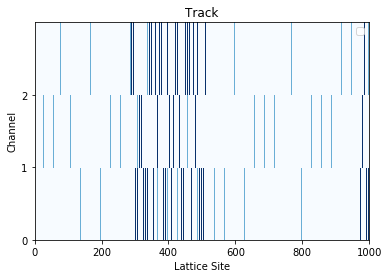

In [31]:
np.random.seed(0)
track = np.zeros((numRows, numColumns), dtype = np.int8)  ### Track is our model on which we place motors

from time import time
n_epochs = 500    #### The model is ran for 500 epochs here, 
start = time()
simulate_model(n_epochs)
end=time()
# Print run time
print((end - start) / float(n_epochs))  ### Average time for one epoch